<a href="https://colab.research.google.com/github/Halilibrahim-Guc/Iowa-State-University-Enrollment-Prediction-with-XGBoostost/blob/main/Iowa_Prediction_with_LightGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.preprocessing import OrdinalEncoder

In [40]:
# Load the dataset into a pandas DataFrame
df = pd.read_csv('/content/ISU Enrollment Data Set.zip')
df.head(601)

,Year,Semester,Ungrad,Prof,Grad,Post-Doc,Total
0,2022,Spring,24482,632,4122,0,29236
1,2021,Fall,25808,636,4264,0,30708
2,2021,Summer,6202,159,2713,0,9074
3,2021,Spring,24482,621,4265,0,29368
4,2020,Fall,26846,627,4352,0,31825
...,...,...,...,...,...,...,...
66,2000,Spring,20251,0,4082,0,24333
67,1999,Fall,21901,0,4209,0,26110
68,1999,Summer,6033,0,2858,0,8891
69,1999,Spring,19825,0,4048,0,23873


In [24]:
# Since there are many missing Post-Doc values, and Professional Promans have low enrollment, they are combined
df["Prof"] = df["Prof"] + df["Post-Doc"]
df = df.drop(['Post-Doc'], axis = 1)
df.rename(columns = {'Prof':'Prof and Post-Doc'}, inplace = True)

df.head()

,Year,Semester,Ungrad,Prof and Post-Doc,Grad,Total
0,2022,Spring,24482,632,4122,29236
1,2021,Fall,25808,636,4264,30708
2,2021,Summer,6202,159,2713,9074
3,2021,Spring,24482,621,4265,29368
4,2020,Fall,26846,627,4352,31825


In [25]:
# Encode nominal categories
enc = OrdinalEncoder()
df['Semester'] = enc.fit_transform(df[["Semester"]])

df.head()

,Year,Semester,Ungrad,Prof and Post-Doc,Grad,Total
0,2022,1.0,24482,632,4122,29236
1,2021,0.0,25808,636,4264,30708
2,2021,2.0,6202,159,2713,9074
3,2021,1.0,24482,621,4265,29368
4,2020,0.0,26846,627,4352,31825


In [27]:
# Extract the features and target variable from the DataFrame
X = df.iloc[:, :-1]
y = df[['Total']]
print(X.shape, y.shape)

(71, 5) (71, 1)


In [28]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
# Define the LightGBM model
lgb_model = lgb.LGBMRegressor(
    task = 'predict',
    application = 'regression',
    objective = 'root_mean_squared_error',
    boosting_type="gbdt",
    num_iterations = 2500,
    learning_rate = 0.05,
    num_leaves=15,
    tree_learner='feature',
    max_depth =10,
    min_data_in_leaf=7,
    bagging_fraction = 1,
    bagging_freq = 100,
    reg_sqrt='True',
    metric ='rmse',
    feature_fraction = 0.6,
    random_state=42)

lgb_model.fit(X_train,y_train) 

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] bagging_freq is set=100, subsample_freq=0 will be ignored. Current value: bagging_freq=100
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


LGBMRegressor(application='regression', bagging_fraction=1, bagging_freq=100,
              feature_fraction=0.6, learning_rate=0.05, max_depth=10,
              metric='rmse', min_data_in_leaf=7, num_iterations=2500,
              num_leaves=15, objective='root_mean_squared_error',
              random_state=42, reg_sqrt='True', task='predict',
              tree_learner='feature')

In [37]:

# Evaluate the performance of the model on the test data using RMSE
y_pred = lgb_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE: %.3f' % rmse)

RMSE: 710.529


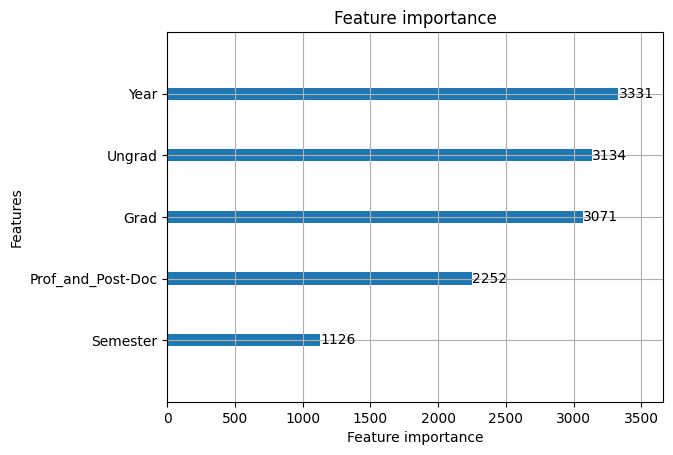

<Figure size 1600x1200 with 0 Axes>

In [38]:

# Show the feature importance
lgb.plot_importance(lgb_model)
plt.figure(figsize = (16, 12))
plt.show()

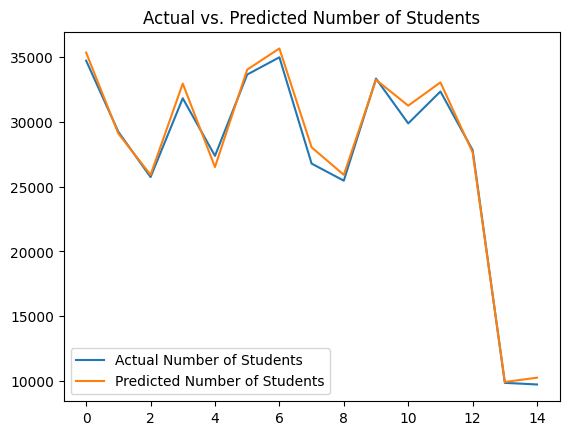

In [39]:
# Plot the predicted values against the actual values on a scatter plot
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="Actual Number of Students")
plt.plot(x_ax, y_pred, label="Predicted Number of Students")
plt.title('Actual vs. Predicted Number of Students')
plt.legend()
plt.show()